# Rank Model

This model will rank the items generated by the candidates model and sort recommendations due to the ranked output

In [21]:
import pandas as pd
import os, sys
import numpy as np
import seaborn as sns
import gc
import warnings

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from gensim.models import Word2Vec

from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          LSTM, GRU, concatenate, Bidirectional, \
                          Reshape, Dropout, GlobalAveragePooling1D

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from custom_functions import norm_text, norm_brands, norm_images

pd.set_option('max_colwidth', 250)
warnings.filterwarnings(action='once')

## Load Data

In [2]:
path = os.path.join('../../Data/')
path_text_encoders = os.path.join('../03_Preparacion_de_Datos/')
data = pd.read_csv(path + 'data_filtered_20190422.csv', sep = ';')
data_processed = pd.read_csv('data_final_20190524.csv')
data_processed['text'] = data_processed['text'].astype(str)

In [3]:
data_processed.head(3)

,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score,score_original,power_price,power_score,power_item_age,sqrt_price,sqrt_score,sqrt_item_age
0,20190101,A26036172,tintoretto,0.003198,0,vestido mujer flor lazada,0.0,0,0,0,0.001485,4,0.000010,0.000002,0.0,0.056548,0.038538,0.0
1,20190101,A26870590,fórmula joven,0.002260,0,vestido laminado mujer formula joven escote pico,0.0,0,1,1,0.001485,4,0.000005,0.000002,0.0,0.047539,0.038538,0.0
2,20190103,MP_0659870_3014,gabrielle,0.008837,1,abrigo mujer negro avalorios,0.0,1,2,2,0.000000,1,0.000078,0.000000,0.0,0.094005,0.000000,0.0


In [4]:
items_unique = data_processed.item_id.unique()
items_map = {i:val for i,val in enumerate(items_unique)}
items_map_inv = {val:i for i,val in enumerate(items_unique)}
items_map_text = data_processed.set_index('item_id_int').text.to_dict()

customers_unique = data_processed.customer_id.unique()
items_unique = data_processed.item_id.unique()
brand_unique = data_processed.brand.unique()

In [5]:
MAX_NB_WORDS = 30_000 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 24 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 100 #Same dim as our W2V embedding

all_text = data_processed['text']
all_text = all_text.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_text)

data_sequences = tokenizer.texts_to_sequences(data_processed['text'])
data_vec = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8487 unique tokens.


### Load Embedding

In [6]:
modelWV = Word2Vec.load(path_text_encoders + 'word2vec_model_v2')

word_vectors = modelWV.wv
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in modelWV:
        embedding_matrix[i] = modelWV[word]
    else:
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]
            

del(word_vectors)

#embedding_layer = Embedding(input_dim = vocabulary_size,
#                            output_dim = EMBEDDING_DIM,
#                            input_length = MAX_SEQUENCE_LENGTH,
#                            weights=[embedding_matrix],
#                            name='w2v_embedding',
#                            trainable=False)

C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


## Build rank model

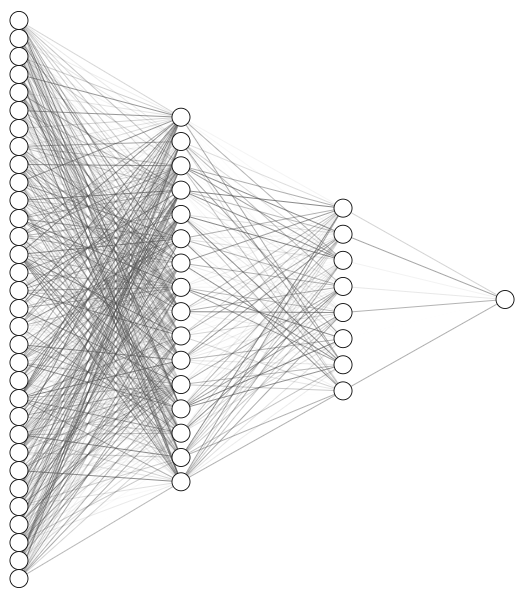

In [7]:
scaler = MinMaxScaler()
data_to_scale = data_processed[['PRICE','score', 'item_age']]
scaled_data = data_to_scale.values

In [105]:
def get_rank_model():
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')
    brand_id_input = Input(shape = [1], name = 'brand')

    price_input = Input(shape = [1], name = 'price')
    item_age_input = Input(shape = [1], name = 'item_age')

    price_power_input = Input(shape = [1], name = 'power_price')
    item_age_power_input = Input(shape = [1], name = 'power_item_age')

    price_sqrt_input = Input(shape = [1], name = 'sqrt_price')
    item_age_sqrt_input = Input(shape = [1], name = 'sqrt_item_age')


    #sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH, ), name = 'text')

    embedding_size = 20
    item_embedding_size = 40

    user_embedding = Embedding(output_dim=embedding_size, input_dim = customers_unique.shape[0]+1,
                               input_length=1, name='user_embedding')(user_id_input)
    item_embedding = Embedding(output_dim=item_embedding_size, input_dim = items_unique.shape[0]+1,
                               input_length=1, name='item_embedding')(item_id_input)
    brand_embedding = Embedding(output_dim=embedding_size, input_dim = brand_unique.shape[0]+1,
                               input_length=1, name='brand_embedding')(brand_id_input)

    #text_embedding = Embedding(*embedding_matrix.shape, weights = [embedding_matrix], trainable = False)(sequence_input)

    user_vecs = Reshape([embedding_size])(user_embedding)
    item_vecs = Reshape([item_embedding_size])(item_embedding)
    brand_vecs = Reshape([embedding_size])(brand_embedding)
    #text_flat = LSTM(128, dropout = 0.1, recurrent_dropout = 0.2)(text_embedding)
    #text_flat = Flatten()(text_embedding)

    x1 = concatenate([user_vecs, item_vecs, brand_vecs, price_input, item_age_input,
                     price_power_input, item_age_power_input,
                     price_sqrt_input, item_age_sqrt_input], name = 'VECTOR_PRODUCTO')

    x2 = Dropout(0.5)(x1)
    x3 = Dense (512, activation = 'relu', activity_regularizer=l1(0.0001))(x2)
    x4 = Dropout(0.4)(x3)
    x5 = Dense(256, activation = 'relu', activity_regularizer=l1(0.0001))(x4)
    x6 = Dropout(0.3)(x5)
    x7 = Dense(128, activation = 'relu',activity_regularizer=l1(0.0001))(x6)
    x8 = Dropout(0.2)(x7)

    output = Dense(1, activation = 'linear' )(x8)

    model = Model(inputs=[user_id_input, item_id_input, brand_id_input, price_input, item_age_input,
                         price_power_input, item_age_power_input,
                         price_sqrt_input, item_age_sqrt_input], 
                  outputs = output)

    model.compile(loss = 'mse',
                  optimizer = 'rmsprop',
                  metrics = ['acc'])

    model.summary()
    
    return model

In [106]:
#candidates = load_model('candidate_generation_20190525')
#weights_user = candidates.get_weights()[0]
#weights_item = candidates.get_weights()[1]
#weights_brand = candidates.get_weights()[2]

rank_model = get_rank_model()

history = rank_model.fit([data_processed['customer_id_int'], data_processed['item_id_int'], 
                     data_processed['brand_id'], data_processed['PRICE'],
                     data_processed['item_age'],
                     data_processed['power_price'], data_processed['power_item_age'],
                     data_processed['sqrt_price'], data_processed['sqrt_item_age']],
                     data_processed['score_original'],
                     epochs = 30,
                     batch_size = 256, 
                     shuffle = True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
brand (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        11360       user[0][0]                       
__________________________________________________________________________________________________
item_embed

25749/25749 [==============================] - 3s 116us/sample - loss: 198.7157 - acc: 0.6711
Epoch 22/30
25749/25749 [==============================] - 3s 115us/sample - loss: 289.1861 - acc: 0.6828
Epoch 23/30
25749/25749 [==============================] - 3s 117us/sample - loss: 216.0562 - acc: 0.6846
Epoch 24/30
25749/25749 [==============================] - 4s 152us/sample - loss: 240.0608 - acc: 0.6871
Epoch 25/30
25749/25749 [==============================] - 3s 112us/sample - loss: 146.9855 - acc: 0.6764
Epoch 26/30
25749/25749 [==============================] - 3s 106us/sample - loss: 246.2802 - acc: 0.6847
Epoch 27/30
25749/25749 [==============================] - 3s 101us/sample - loss: 193.6992 - acc: 0.6805s - loss: 197.3764 - acc: 0.67
Epoch 28/30
25749/25749 [==============================] - 3s 109us/sample - loss: 237.3613 - acc: 0.6917
Epoch 29/30
25749/25749 [==============================] - 3s 112us/sample - loss: 348.8201 - acc: 0.6795s - loss: 358.450
Epoch 30/30

In [107]:
rank_model.save('rank_model_20190525')

In [108]:
preds = rank_model.predict([data_processed['customer_id_int'], data_processed['item_id_int'], 
                     data_processed['brand_id'], data_processed['PRICE'],
                     data_processed['item_age'],
                     data_processed['power_price'], data_processed['power_item_age'],
                     data_processed['sqrt_price'], data_processed['sqrt_item_age']], verbose = 1)

25749/25749 [==============================] - 4s 149us/sample


In [109]:
preds.shape

(25749, 1)

In [110]:
preds[:10]

array([[3.3818996 ],
       [4.5213246 ],
       [0.78267926],
       [0.741892  ],
       [0.7637625 ],
       [9.716716  ],
       [9.716716  ],
       [0.8688928 ],
       [0.87695515],
       [0.8326781 ]], dtype=float32)

In [111]:
data_processed['score_original'][:10]

0     4
1     4
2     1
3     1
4     1
5    10
6    10
7     1
8     1
9     1
Name: score_original, dtype: int64

In [112]:
c_idx = data_processed.index[data_processed['customer_id_int'] == 128] 
data_processed[data_processed['customer_id_int'] == 128]

,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score,score_original,power_price,power_score,power_item_age,sqrt_price,sqrt_score,sqrt_item_age
980,20190120,A16759315,dustin,0.003432,128,chaqueta punto hombre cuello alto,0.0,128,898,229,0.0,1,0.000012,0.0,0.0,0.058584,0.0,0.0
981,20190120,A24965927,dustin,0.002963,128,jersey hombre cuello redondo,0.0,128,899,229,0.0,1,0.000009,0.0,0.0,0.054435,0.0,0.0
1747,20190120,A27344180,esprit,0.002841,128,jersey hombre gris oscuro cuello caja,0.0,128,1580,257,0.0,1,0.000008,0.0,0.0,0.053304,0.0,0.0
2242,20190120,A4690016,warner bros entertainment,0.005542,128,pack harry_potter coleccion completa bluray,0.0,128,2002,325,0.0,1,0.000031,0.0,0.0,0.074444,0.0,0.0
2243,20190120,A10317195,warner bros entertainment,0.003549,128,harry_potter reliquia muerte parte 3d bluray copia digital,0.0,128,2003,325,0.0,1,0.000013,0.0,0.0,0.059576,0.0,0.0
2244,20190120,A12070559,warner bros entertainment,0.019726,128,harry_potter coleccion hogwarts dvd bluray,0.0,128,2004,325,0.0,1,0.000389,0.0,0.0,0.140450,0.0,0.0
2245,20190120,A13453366,warner bros entertainment,0.001557,128,harry_potter piedra filosofal dvd,0.0,128,2005,325,0.0,1,0.000002,0.0,0.0,0.039454,0.0,0.0
2246,20190120,A13453371,warner bros entertainment,0.001557,128,harry_potter camara secreta dvd,0.0,128,2006,325,0.0,1,0.000002,0.0,0.0,0.039454,0.0,0.0
2247,20190120,A13453375,warner bros entertainment,0.001557,128,harry_potter prisionero azkaban dvd,0.0,128,2007,325,0.0,1,0.000002,0.0,0.0,0.039454,0.0,0.0
2248,20190120,A13453380,warner bros entertainment,0.001557,128,harry_potter caliz fuego dvd,0.0,128,2008,325,0.0,1,0.000002,0.0,0.0,0.039454,0.0,0.0


In [113]:
preds[c_idx]

array([[0.7360991 ],
       [0.7618878 ],
       [0.79860127],
       [0.7753073 ],
       [0.77675647],
       [0.7760584 ],
       [0.7575042 ],
       [0.83689153],
       [0.76359385],
       [0.75071836],
       [0.7674376 ]], dtype=float32)

---